<a href="https://colab.research.google.com/github/yurkovak/ViT_notebook/blob/main/Vision_Transormer_(ViT)_under_the_magnifying_glass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hi! 👋
This is a complementary notebook to the article [Vision Transormer (ViT) under the magnifying glass](https://). It contains the same code that was published there, except in this Colab notebook you can actually run it and experiment. Please refer to the article for the explanation of what is going on here.

**Disclaimer:** You can make any changes you like, they won't impact the remote copy, but please note that they will be lost after you refresh the page.

Install the dependencies first:

In [1]:
%pip install torch transformers > /dev/null

import copy
import math
from typing import Union, List

import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import ViTForImageClassification

# Embeddings

## 1.1 Patch embeddings

Linear embedding:

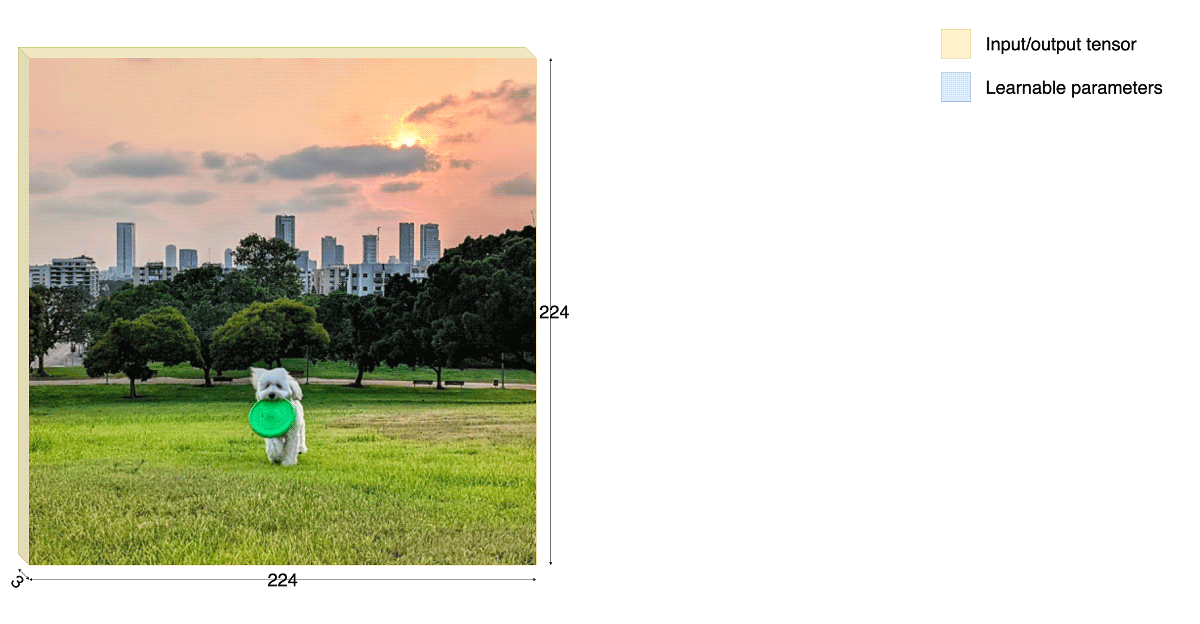

Flattening:

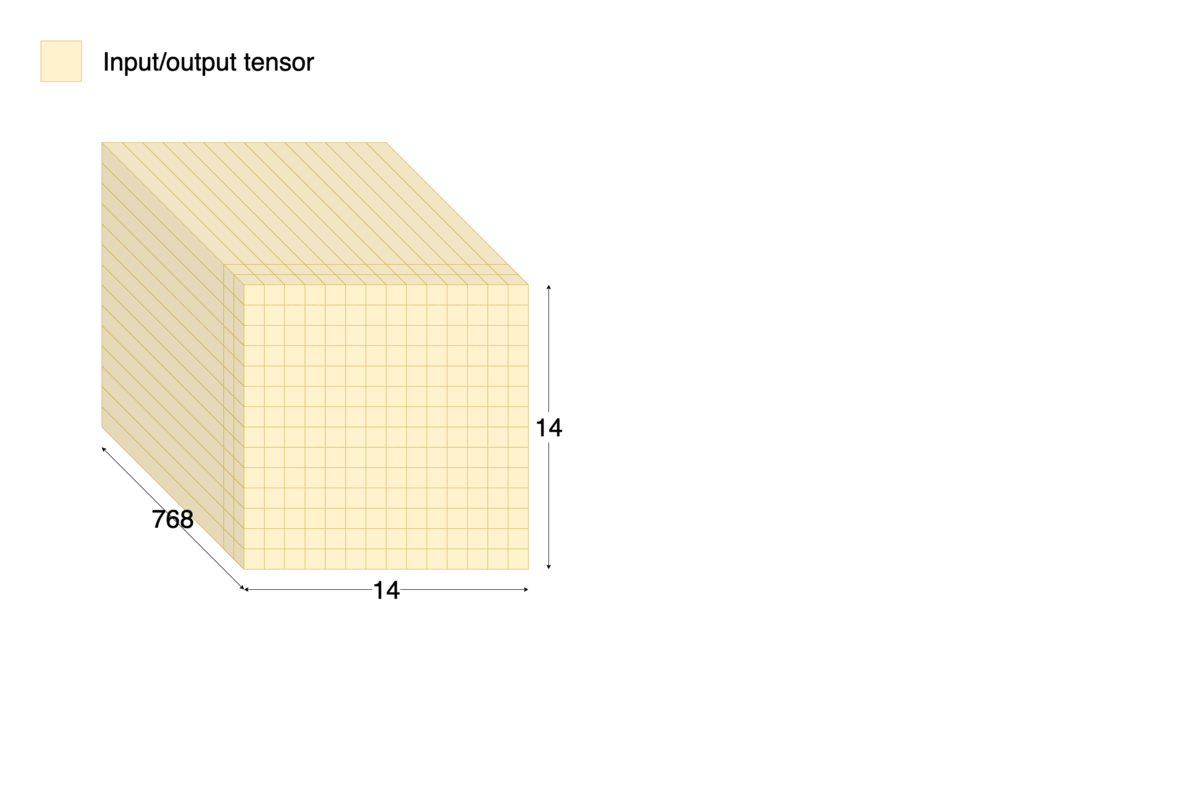

In [2]:
im_h, im_w = 224, 224
num_channels = 3
input_image = torch.ones((1, num_channels, im_h, im_w))  # torch.Size([1, 3, 224, 224])
patch_size = 16
hidden_size = 768
projection = torch.nn.Conv2d(num_channels, hidden_size,
                             kernel_size=patch_size, stride=patch_size)
x = projection(input_image)  # torch.Size([1, 768, 14, 14])
embeddings = x.flatten(2).transpose(1, 2)  # torch.Size([1, 196, 768]), 196 = 14*14

Let's see that the same result can be achieved both with Conv2d and Linear:

In [3]:
embeddings_conv = embeddings

# Copy weights from Conv2d into Linear
conv_weight = projection.weight  # torch.Size([768, 3, 16, 16])
conv_bias = projection.bias  # torch.Size([768])
linear_projection = torch.nn.Linear(patch_size * patch_size * num_channels, hidden_size)
linear_projection.weight = torch.nn.Parameter(copy.deepcopy(conv_weight).flatten(1))  # torch.Size([768, 768])
linear_projection.bias = torch.nn.Parameter(copy.deepcopy(conv_bias))  # torch.Size([768])

# Patchify the image and project with Linear
patched_image = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)(input_image)  # torch.Size([1, 768, 196])
patched_sequence = patched_image.transpose(1, 2)  # torch.Size([1, 196, 768])
embeddings_linear = linear_projection(patched_sequence)

# Compare the results of Linear and Conv2d
print('Outputs of Linear and Conv2d match:', 
      torch.allclose(embeddings_conv, embeddings_linear, atol=1e-03))  # prints True

Outputs of Linear and Conv2d match: True


## 1.2. (Optional) Positional masking

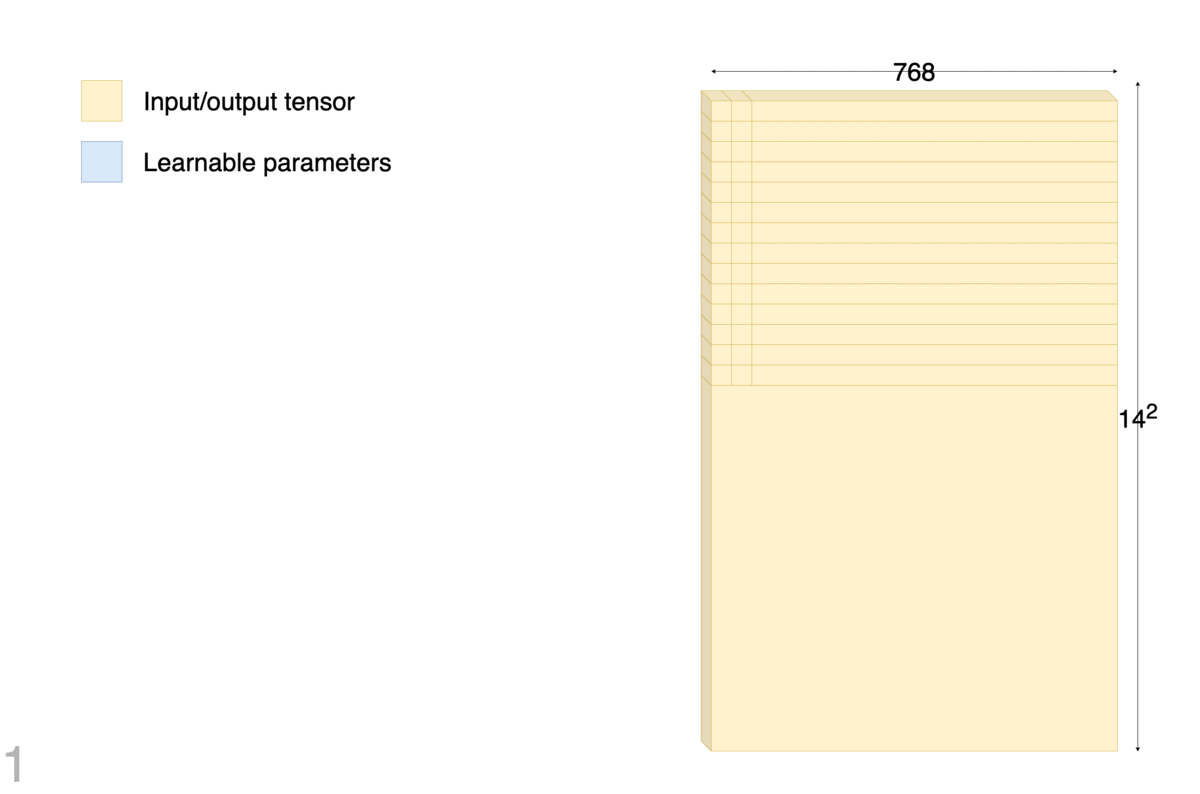

In [4]:
batch_size, seq_length = embeddings.shape[:2]  # 1 and 196 = 14*14

# Define a learnable [MASK] token, requires_grad is True by default
mask_token = torch.nn.Parameter(torch.zeros(1, 1, hidden_size))  # torch.Size([1, 1, 768])

# Create a binary mask, choose to mask out 4th and 20th patches as an example
bool_masked_pos = torch.zeros((seq_length,))  # torch.Size([196])
bool_masked_pos[4] = 1.
bool_masked_pos[20] = 1.

# Replace patch embeddings with mask token on the selected positions
mask_tokens = mask_token.expand(batch_size, seq_length, -1)  # torch.Size([1, 196, 768])
masked_positions = bool_masked_pos.unsqueeze(-1).type_as(mask_tokens)  # torch.Size([196, 1])
embeddings = embeddings * (1.0 - masked_positions) + mask_tokens * masked_positions  # torch.Size([1, 196, 768])

# Compare new embeddings to [MASK] token
print('The 4th token matches the 20th token', torch.equal(embeddings[:, 4], embeddings[:, 20]))  # prints True
print('The 4th token matches the [MASK] token', torch.equal(embeddings[:, 4], mask_token.squeeze(1)))  # prints True

The 4th token matches the 20th token True
The 4th token matches the [MASK] token True


Alternative implementation of masking:

In [5]:
positions_to_mask = [4, 20]
embeddings[:, positions_to_mask] = mask_token.expand(batch_size, len(positions_to_mask), -1)

## 1.3 [CLS] token

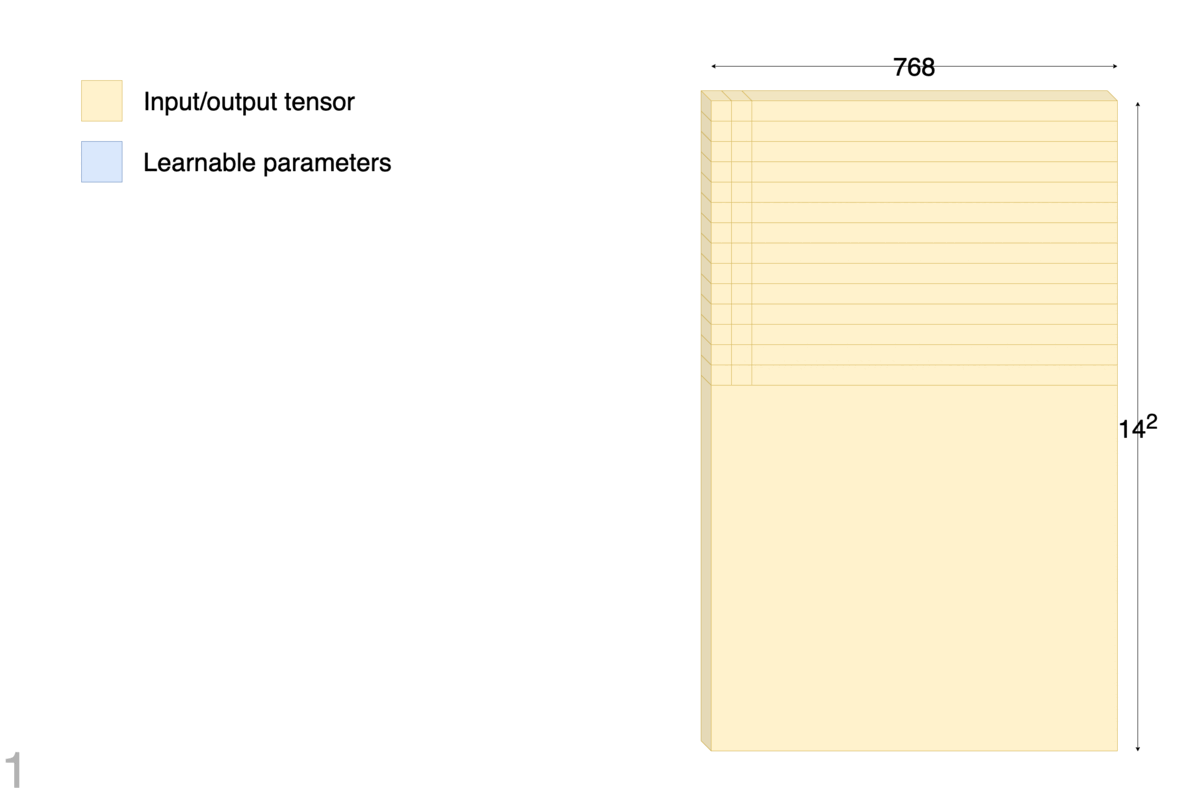

In [6]:
# Initialize [CLS] token parameters
cls_token = torch.nn.Parameter(torch.zeros(1, 1, hidden_size))  # torch.Size([1, 1, 768])

# Stack [CLS] token to other embeddings 
cls_tokens = cls_token.expand(batch_size, -1, -1)  # torch.Size([1, 1, 768])
embeddings = torch.cat((cls_tokens, embeddings), dim=1)  # torch.Size([1, 197, 768])

# Check new sequence length
new_seq_length = embeddings.shape[1]
print('New sequence length:', new_seq_length)  # prints 197 = 14*14 + 1

New sequence length: 197


## 1.4 Positional embedding

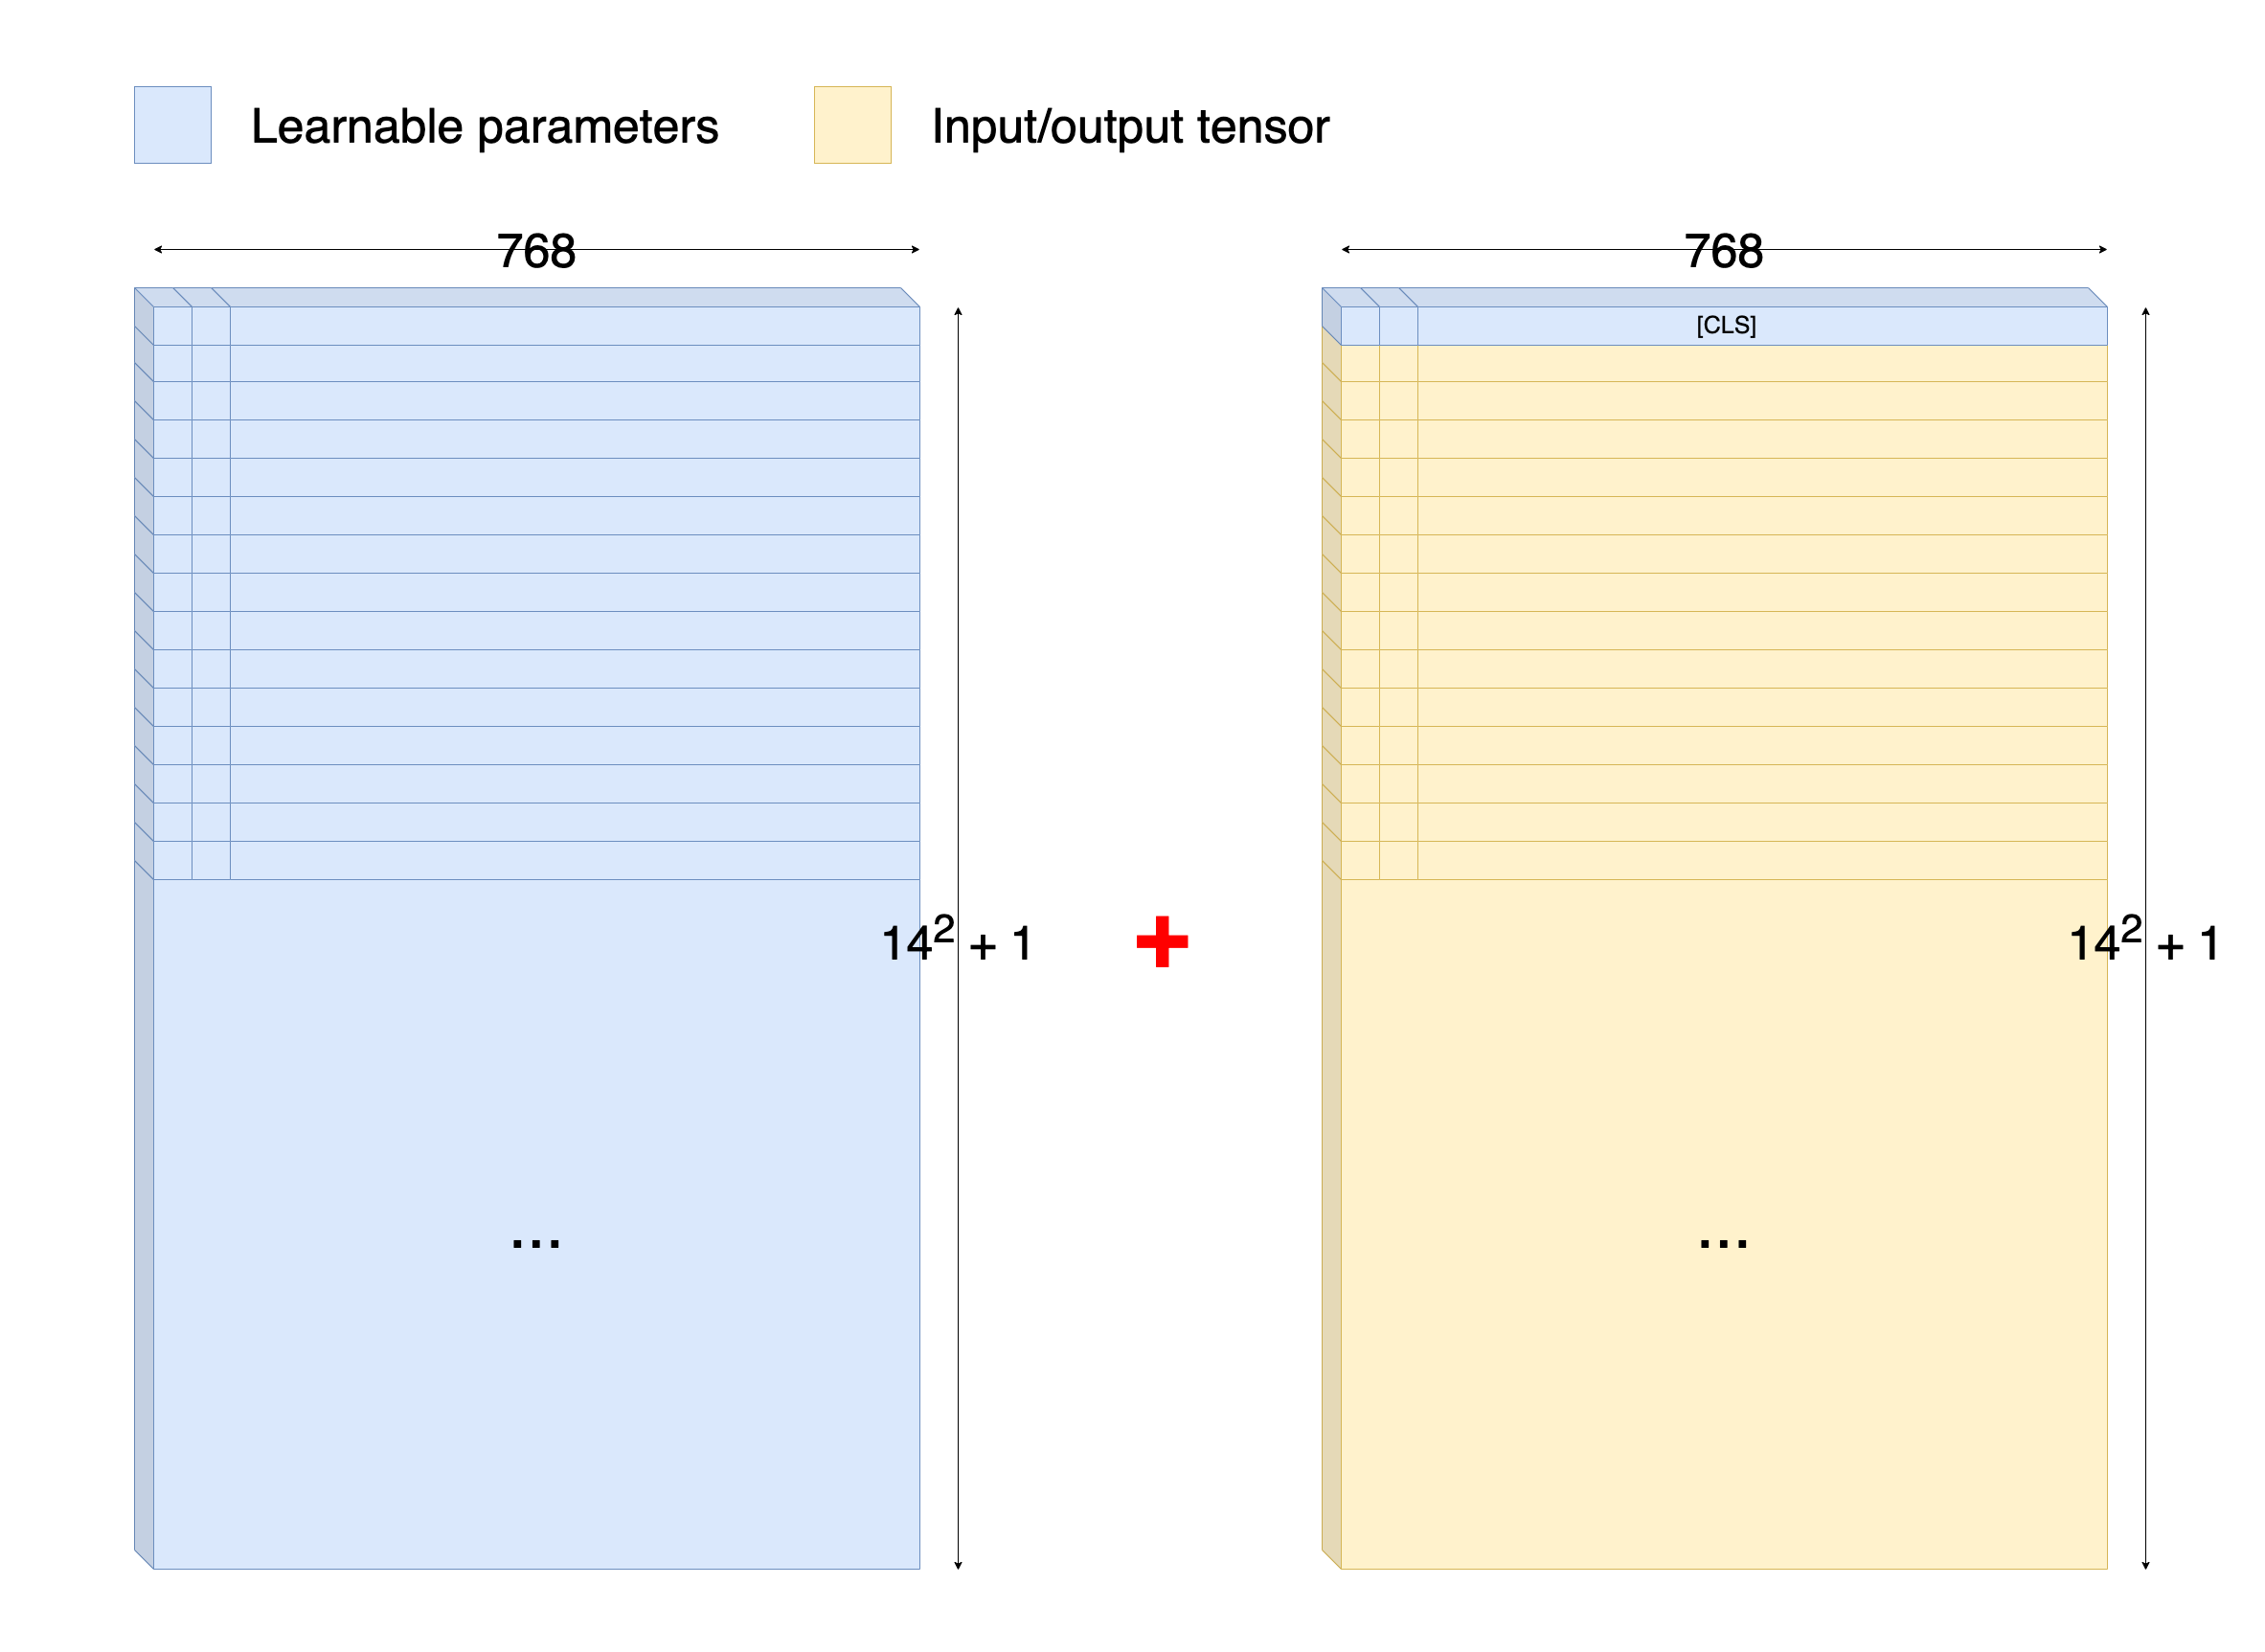

In [7]:
# Initialize position_embeddings parameters and add to the sequence embeddings
position_embeddings = torch.nn.Parameter(torch.zeros(1, new_seq_length, hidden_size))  # torch.Size([1, 197, 768])
embeddings = embeddings + position_embeddings  # torch.Size([1, 197, 768])

Let's reproduce the Figure 10 from the paper ("[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)"). For this we'll need a few helper functions:

In [8]:
def visualize_heatmaps(similarity_heatmaps: Union[np.ndarray, List[List]], grid_h: int, grid_w: int) -> None:
    """
    Plot grid_h x grid_w subplots, each containing a cosine similarity map in (-1, 1)
    :param similarity_heatmaps: grid_h x grid_w array of similarity heatmaps,
                                where similarity_heatmaps[i][j] stores similarity between embedding
                                for the patch at (i, j) to all the other embeddings
    :param grid_h:              number of patches along Y axis
    :param grid_w:              number of patches along X axis
    """
    fig, ax = plt.subplots(grid_h, grid_w, figsize=(15, 15))
    fontsize = 24

    for i in range(grid_h):
        for j in range(grid_w):
            im = ax[i, j].imshow(similarity_heatmaps[i][j], vmin=-1, vmax=1)
            if i == grid_h - 1:
                ax[i, j].set_xlabel(j + 1, fontsize=fontsize, rotation='horizontal')
            if j == 0:
                ax[i, j].set_ylabel(i + 1, fontsize=fontsize)
            ax[i, j].tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), aspect=25, ticks=[-1, 1])
    cbar.set_label('Cosine similarity', rotation=-270, fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    fig.text(0.45, 0.04, 'Input patch row', ha='center', fontsize=fontsize)
    fig.text(0.04, 0.5, 'Input patch column', va='center', rotation='vertical', fontsize=fontsize)
    plt.show()


def similarity_one_to_all(pos_embedding: torch.tensor, all_embeddings: torch.tensor) -> np.ndarray:
    cos_sim = torch.nn.CosineSimilarity(dim=-1)
    similarities = []
    # Compare the given pos_embedding to all other embeddings one by one
    for i in range(len(all_embeddings)):
        similarity = cos_sim(pos_embedding, all_embeddings[i])  # one values
        similarities.append(similarity)
    return np.array(similarities)


def similarity_all_to_all(pos_embeddings: torch.tensor, grid_h: int, grid_w: int) -> List[List]:
    """
    Compute similarity between  positional embeddings, all to all
    :param pos_embeddings:  embeddings of shape (sequence_length x D),
                            sequence_length must be equal to grid_h * grid_w
    :param grid_h:          number of patches along Y axis
    :param grid_w:          number of patches along X axis
    :return:                grid_h x grid_w array of similarity heatmaps,
                            where similarity_heatmaps[i][j] stores similarity between embedding
                            for the patch at (i, j) to all the other embeddings
    """
    # Reshape pos. embeddings into a grid
    pos_embeddings_grid = pos_embeddings.reshape((grid_h, grid_w, -1))
    similarity_heatmaps = []
    # Go over patches rows
    for i in range(grid_h):
        row_i_heatmaps = []
        # Go over patches columns
        for j in range(grid_w):
            # Compare pos. embedding (i, j) to all other embeddings and reshape similarities into a heatmap
            similarities = similarity_one_to_all(pos_embeddings_grid[i, j], pos_embeddings)
            row_i_heatmaps.append(similarities.reshape((grid_h, grid_w)))
        similarity_heatmaps.append(row_i_heatmaps)

    return similarity_heatmaps

def similarity_all_to_all_vectorized(pos_embeddings: torch.tensor, grid_h: int, grid_w: int) -> np.ndarray:
    """
    Vectorized implementation of similarity_all_to_all
    """
    seq_length = pos_embeddings.shape[0]
    # E1, E1, E1, ..., E2, E2, E2, ...
    x = pos_embeddings.repeat_interleave(seq_length, 0)  # e.g. torch.Size([38416, 768]), 38416 = 196 * 196
    # E1, E2, E3, ..., E1, E2, E3, ...
    y = pos_embeddings.tile((seq_length, 1))  # e.g. torch.Size([38416, 768])
    similarities = torch.nn.CosineSimilarity(dim=-1)(x, y)
    return similarities.view((grid_h, grid_w, grid_h, grid_w)).numpy()

Usizing the functions above, let's visualize the model's positional embeddings.  
Note that the functions `similarity_all_to_all_vectorized(...)` and `similarity_all_to_all_vectorized(...)` can be used interchangeably. 

Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

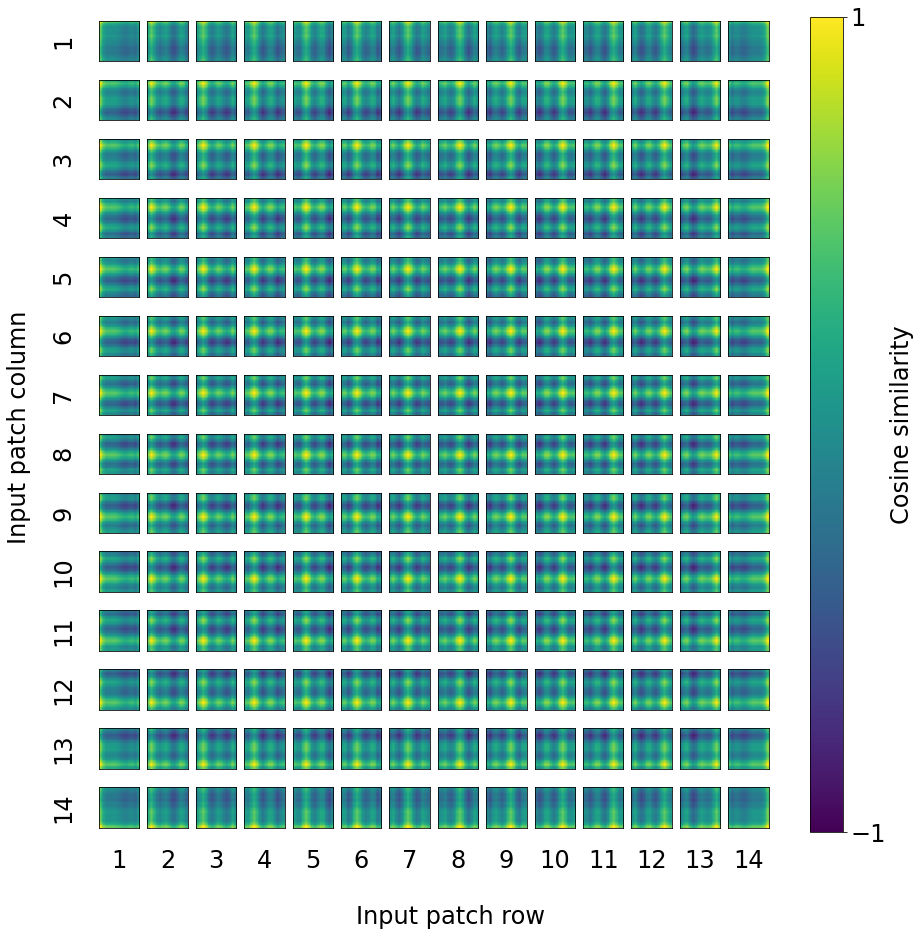

In [9]:
# Load pre-trained ViT-B/16 and get its position embedding
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
trained_pos_embeddings_all = model.vit.embeddings.position_embeddings[0].detach()  # torch.Size([197, 768])

# Discard batch dimension and [CLS] token position
image_pos_embeddings = trained_pos_embeddings_all[1:]  # torch.Size([196, 768])
grid_h, grid_w = im_h // patch_size, im_w // patch_size

# Compute similarities and visualize
similarity_heatmaps = similarity_all_to_all_vectorized(image_pos_embeddings, grid_h, grid_w)
visualize_heatmaps(similarity_heatmaps, grid_h, grid_w)

Let's compare the positional embedding of [CLS] token to all other pos. embeddings:

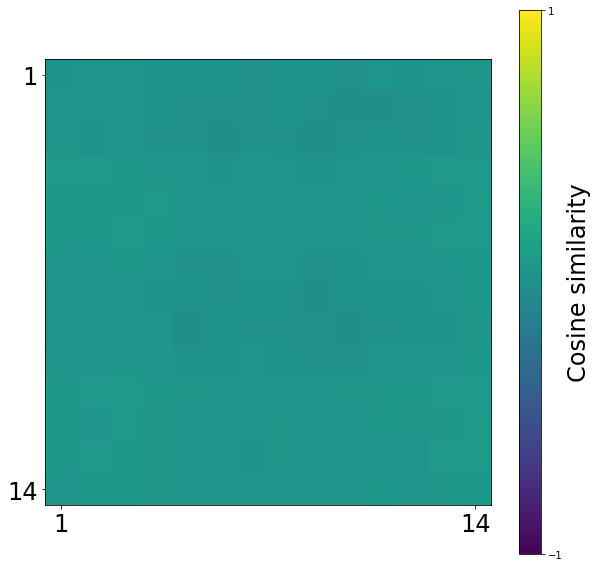

In [10]:
# Get positional embedding that corresponds to the [CLS] token
cls_pos_pos_embedding = trained_pos_embeddings_all[0]  # 0-th position, torch.Size([768])

# Visualize similarity between [CLS] token PE to all other PE-s
cls_pos_to_all_similarity = similarity_one_to_all(cls_pos_pos_embedding, image_pos_embeddings)
plt.figure(figsize=(10, 10))
plt.imshow(cls_pos_to_all_similarity.reshape((grid_h, grid_w)), vmin=-1, vmax=1)
cbar = plt.colorbar(aspect=25, ticks=[-1, 1], label='Cosine similarity')
cbar.set_label(label='Cosine similarity', fontsize=24)
plt.xticks([0, grid_w - 1], labels=[1, grid_w], fontsize=24)
plt.yticks([0, grid_h - 1], labels=[1, grid_h], fontsize=24)
plt.show()

Let's test fixed positional encoding from NLP Transformer ("[Attention Is All You Need](https://arxiv.org/abs/1706.03762)").

In [11]:
def get_fixed_pos_encodings(sequence_length: int, D: int) -> torch.tensor:
    """
    Create positional encodings according to the formula used for Transformer in
    "Attention Is All You Need"
    """
    position = torch.arange(sequence_length).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, D, 2) * (-math.log(10000.0) / D))
    pe = torch.zeros(sequence_length, D)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

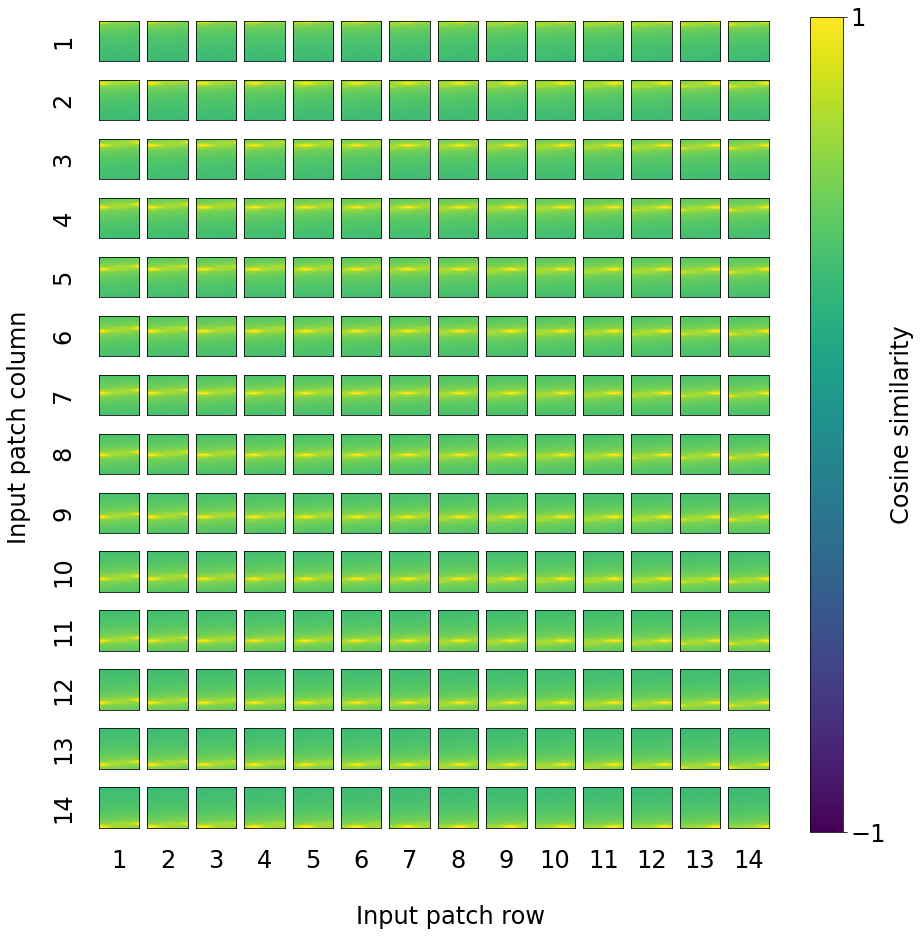

In [12]:
# Create fixed positional encoding and visualize similarities
fixed_pos_encodings = get_fixed_pos_encodings(grid_h * grid_w + 1, hidden_size)  # torch.Size([197, 768])
similarity_heatmaps_fixed = similarity_all_to_all(fixed_pos_encodings[1:], grid_h, grid_w)
visualize_heatmaps(similarity_heatmaps_fixed, grid_h, grid_w)

Compare absolute values:

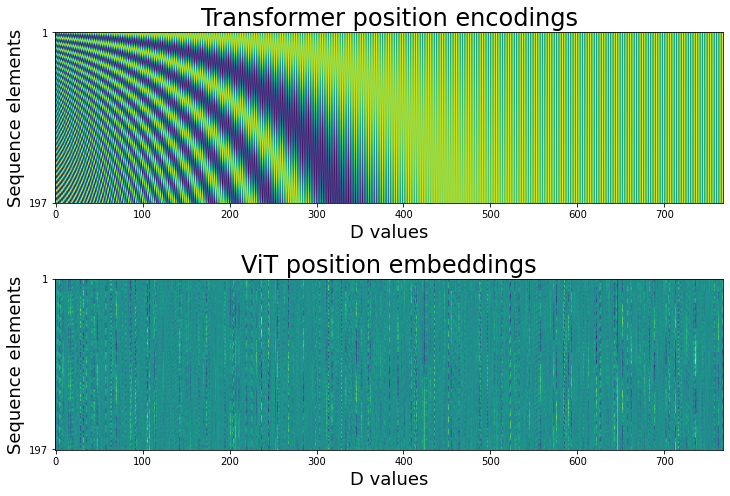

In [13]:
# Visualize absolute values of learned position encodings of ViT and fixed encodings of Transformer
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
fig.tight_layout()
for i, (pos, title) in enumerate([(fixed_pos_encodings, 'Transformer position encodings'),
                                  (trained_pos_embeddings_all, 'ViT position embeddings')]):
    ax[i].set_title(title, fontsize=24)
    ax[i].set_yticks([0, 196])
    ax[i].set_yticklabels([1, 197])
    ax[i].set_xlabel('D values', fontsize=18)
    ax[i].set_ylabel('Sequence elements', fontsize=18)
    ax[i].imshow(pos.numpy())
plt.show()

## 1.5 DropOut

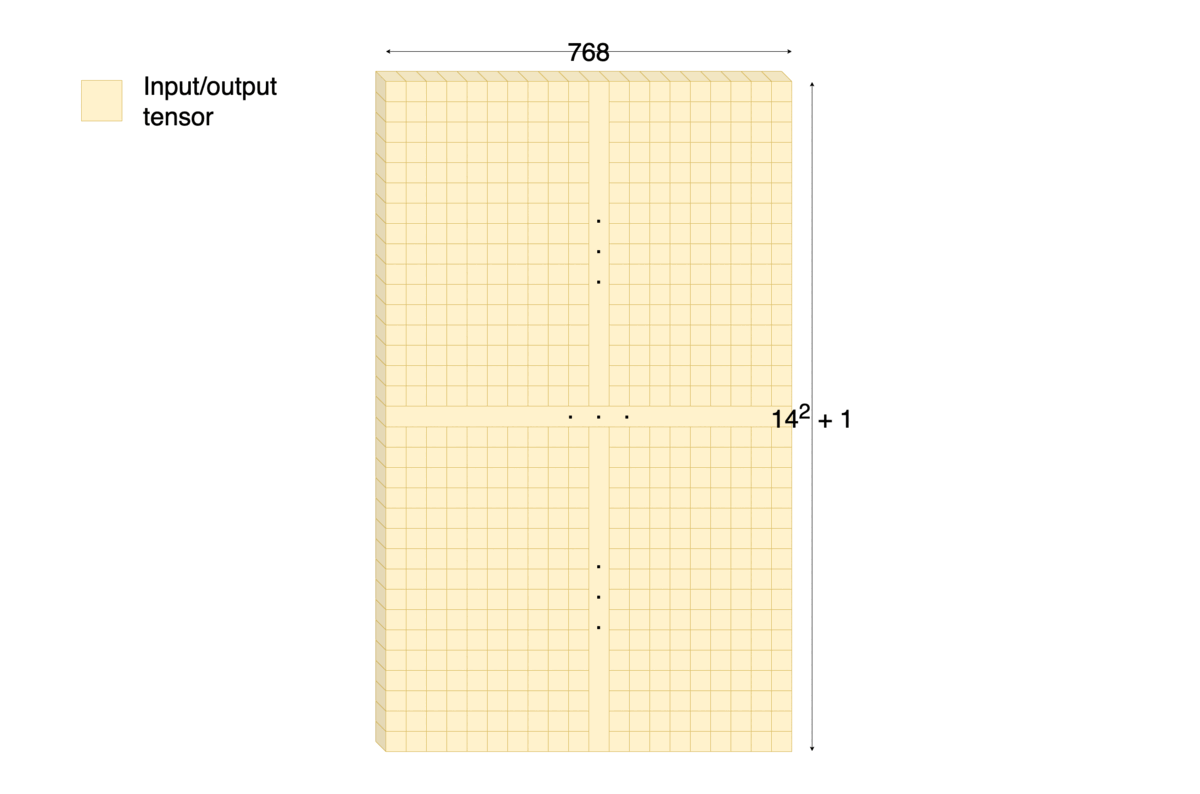

In [14]:
# Define the DropOut layer and apply it in the train mode (the default mode)
dropout_prob = 0.1
dropout = torch.nn.Dropout(dropout_prob)
embeddings_after_train_dp = dropout(embeddings)  # torch.Size([1, 197, 768])

# Apply DropOut to the same input embeddings, but in eval mode
dropout.eval()
with torch.no_grad():
    embeddings_afer_eval_dp = dropout(embeddings)

Let's see what DropOut does to an input in train and val mode. 

In [15]:
# Count zero values percentage before and after the operation
with torch.no_grad():
    get_zeros_percentage = lambda t: round(((t == 0.).sum() / t.numel()).item() * 100, 1)
    print(f'Percentage of zeros BEFORE applying dropout: {get_zeros_percentage(embeddings)}%')
    print(f'Percentage of zeros AFTER applying dropout (train): {get_zeros_percentage(embeddings_after_train_dp)}%')
    print(f'Percentage of zeros AFTER applying dropout (eval): {get_zeros_percentage(embeddings_afer_eval_dp)}%\n')

# Check values before and after the operation
with torch.no_grad():
    embeddings_afer_eval_dp = dropout(embeddings)
    print('Values of input embeddings:\n', embeddings[0, :4, 0].detach())
    print('Values of embeddings after DP (train):\n', embeddings_after_train_dp[0, :4, 0].detach())
    print('Values of input embeddings scaled with 1/(1 - p):\n', embeddings[0, :4, 0]/(1 - dropout_prob))
    print('Values of embeddings after DP (eval):\n', embeddings_afer_eval_dp[0, :4, 0].detach())

Percentage of zeros BEFORE applying dropout: 1.5%
Percentage of zeros AFTER applying dropout (train): 11.4%
Percentage of zeros AFTER applying dropout (eval): 1.5%

Values of input embeddings:
 tensor([ 0.0000, -0.4660, -0.4660, -0.4660])
Values of embeddings after DP (train):
 tensor([ 0.0000, -0.5178, -0.5178, -0.5178])
Values of input embeddings scaled with 1/(1 - p):
 tensor([ 0.0000, -0.5178, -0.5178, -0.5178])
Values of embeddings after DP (eval):
 tensor([ 0.0000, -0.4660, -0.4660, -0.4660])
